Mortality Rate = new_cases / population     (In week 3, I did new_deaths_per_million/new_cases_per_million)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install --upgrade plotly
!pip install pmdarima
print("Done")

Requirement already up-to-date: plotly in /usr/local/lib/python3.7/dist-packages (5.1.0)
Done


In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from pprint import pprint
from math import sqrt
import itertools

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn import linear_model
import xgboost as xgb

SEED = 42

In [5]:
df = pd.read_csv("/content/gdrive/MyDrive/owid-covid-data.csv")

In [6]:
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations',
       'new_vaccinations_smoothed', 'total_vaccinations_per_hun

In [7]:
features = ["location", "date", "total_cases", "new_cases", "total_deaths", "new_deaths", "reproduction_rate", "icu_patients", "hosp_patients", 
            "new_tests", "total_tests", "population", ]

In [8]:
dataset_UK = df[df["location"] == "United Kingdom"]  

In [9]:
dataset_UK = dataset_UK[dataset_UK["date"] >= "2020-05-01"]

In [10]:
dataset_UK.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
90078,GBR,Europe,United Kingdom,2020-05-01,183501.0,4730.0,4544.571,27454.0,700.0,654.429,2703.076,69.676,66.944,404.413,10.311,9.640,0.94,2178.0,32.083,14723.0,216.878,NaN,NaN,NaN,NaN,74142.0,996826.0,14.684,1.092,51787.0,0.763,0.088,11.4,tests performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.63,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,NaN
90079,GBR,Europe,United Kingdom,2020-05-02,186731.0,3230.0,4468.286,28039.0,585.0,621.429,2750.655,47.580,65.820,413.031,8.617,9.154,0.90,2068.0,30.463,14380.0,211.826,NaN,NaN,NaN,NaN,63559.0,1060387.0,15.620,0.936,56716.0,0.835,0.079,12.7,tests performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.63,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,NaN
90080,GBR,Europe,United Kingdom,2020-05-03,189708.0,2977.0,4397.429,28292.0,253.0,605.571,2794.508,43.853,64.777,416.757,3.727,8.920,0.87,2009.0,29.594,14188.0,208.997,NaN,NaN,9616.0,141.649,68203.0,1128590.0,16.625,1.005,61943.0,0.912,0.071,14.1,tests performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.63,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,77.33
90081,GBR,Europe,United Kingdom,2020-05-04,193091.0,3383.0,4208.714,28565.0,273.0,598.429,2844.342,49.834,61.997,420.779,4.021,8.815,0.82,1936.0,28.518,14097.0,207.657,NaN,NaN,NaN,NaN,72630.0,1208190.0,17.797,1.070,68805.0,1.014,0.061,16.3,tests performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.63,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,NaN
90082,GBR,Europe,United Kingdom,2020-05-05,196780.0,3689.0,4060.429,29290.0,725.0,563.286,2898.683,54.341,59.812,431.459,10.680,8.298,0.81,1874.0,27.605,13723.0,202.148,NaN,NaN,NaN,NaN,66919.0,1270344.0,18.713,0.986,71218.0,1.049,0.057,17.5,tests performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.63,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,NaN


In [11]:
dataset_UK.tail()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
90482,GBR,Europe,United Kingdom,2021-06-09,4551694.0,7322.0,5871.000,128124.0,6.0,9.571,67049.078,107.857,86.483,1887.340,0.088,0.141,1.48,159.0,2.342,1058.0,15.585,NaN,NaN,NaN,NaN,1085999.0,188125558.0,2771.198,15.997,914986.0,13.478,0.006,155.8,tests performed,69743980.0,40886878.0,28857102.0,492817.0,509036.0,102.74,60.23,42.51,7498.0,NaN,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,NaN
90483,GBR,Europe,United Kingdom,2021-06-10,4558933.0,7239.0,6165.000,128131.0,7.0,8.000,67155.713,106.635,90.814,1887.444,0.103,0.118,NaN,158.0,2.327,1089.0,16.042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70253625.0,41088485.0,29165140.0,509645.0,500570.0,103.49,60.53,42.96,7374.0,NaN,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,NaN
90484,GBR,Europe,United Kingdom,2021-06-11,4566893.0,7960.0,6424.429,128148.0,17.0,8.857,67272.968,117.255,94.636,1887.694,0.250,0.130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70769348.0,41297016.0,29472332.0,515723.0,493108.0,104.25,60.83,43.41,7264.0,NaN,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,NaN
90485,GBR,Europe,United Kingdom,2021-06-12,4574445.0,7552.0,6695.429,128160.0,12.0,8.714,67384.214,111.245,98.628,1887.871,0.177,0.128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71343859.0,41551201.0,29792658.0,574511.0,478468.0,105.09,61.21,43.89,7048.0,NaN,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,NaN
90486,GBR,Europe,United Kingdom,2021-06-13,4581779.0,7334.0,6996.714,128168.0,8.0,9.286,67492.248,108.034,103.066,1887.989,0.118,0.137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,81.32,0.932,NaN


In [12]:
len(dataset_UK)

409

In [13]:
dataset_UK = dataset_UK[features]

In [14]:
dataset_UK["Mortality_Rate"] = " "

In [15]:
dataset_UK["Mortality_Rate"] = dataset_UK["new_deaths"]/dataset_UK["population"]

In [16]:
dataset_UK.isna().sum()

location             0
date                 0
total_cases          0
new_cases            0
total_deaths         0
new_deaths           0
reproduction_rate    4
icu_patients         3
hosp_patients        3
new_tests            4
total_tests          4
population           0
Mortality_Rate       0
dtype: int64

In [17]:
dataset_UK["reproduction_rate"].tail()

90482    1.48
90483     NaN
90484     NaN
90485     NaN
90486     NaN
Name: reproduction_rate, dtype: float64

In [18]:
dataset_UK["icu_patients"].tail()

90482    159.0
90483    158.0
90484      NaN
90485      NaN
90486      NaN
Name: icu_patients, dtype: float64

In [19]:
dataset_UK["hosp_patients"].tail()

90482    1058.0
90483    1089.0
90484       NaN
90485       NaN
90486       NaN
Name: hosp_patients, dtype: float64

In [20]:
dataset_UK["new_tests"].tail()

90482    1085999.0
90483          NaN
90484          NaN
90485          NaN
90486          NaN
Name: new_tests, dtype: float64

In [21]:
dataset_UK["total_tests"].tail()


90482    188125558.0
90483            NaN
90484            NaN
90485            NaN
90486            NaN
Name: total_tests, dtype: float64

In [22]:
dataset_UK.drop(dataset_UK.tail(4).index, inplace=True)

In [23]:
dataset_UK.isna().sum()

location             0
date                 0
total_cases          0
new_cases            0
total_deaths         0
new_deaths           0
reproduction_rate    0
icu_patients         0
hosp_patients        0
new_tests            0
total_tests          0
population           0
Mortality_Rate       0
dtype: int64

In [24]:
dataset_UK["Mortality_Rate"]

90078    1.031140e-05
90079    8.617387e-06
90080    3.726836e-06
90081    4.021447e-06
90082    1.067967e-05
             ...     
90478    1.914975e-07
90479    5.892231e-08
90480    1.473058e-08
90481    2.062281e-07
90482    8.838346e-08
Name: Mortality_Rate, Length: 405, dtype: float64

In [25]:
dataset_UK.columns

Index(['location', 'date', 'total_cases', 'new_cases', 'total_deaths',
       'new_deaths', 'reproduction_rate', 'icu_patients', 'hosp_patients',
       'new_tests', 'total_tests', 'population', 'Mortality_Rate'],
      dtype='object')

In [26]:
feat = ["date", "reproduction_rate", "icu_patients", "Mortality_Rate"]

In [27]:
dataset_UK_models = dataset_UK[feat]

In [28]:
dataset_UK_models.head()

,date,reproduction_rate,icu_patients,Mortality_Rate
90078,2020-05-01,0.94,2178.0,0.000010
90079,2020-05-02,0.90,2068.0,0.000009
90080,2020-05-03,0.87,2009.0,0.000004
90081,2020-05-04,0.82,1936.0,0.000004
90082,2020-05-05,0.81,1874.0,0.000011


In [29]:
dataset_UK_models["date"].dtype

dtype('O')

In [30]:
import datetime as dt
dataset_UK_models['date'] = pd.to_datetime(dataset_UK_models['date'])
dataset_UK_models['date']=dataset_UK_models['date'].map(dt.datetime.toordinal)

In [31]:
dataset_UK_models.head()

,date,reproduction_rate,icu_patients,Mortality_Rate
90078,737546,0.94,2178.0,0.000010
90079,737547,0.90,2068.0,0.000009
90080,737548,0.87,2009.0,0.000004
90081,737549,0.82,1936.0,0.000004
90082,737550,0.81,1874.0,0.000011


In [32]:
dataset_UK_models["date"].dtype

dtype('int64')

In [33]:
len(dataset_UK_models)

405

In [34]:
train = dataset_UK_models[ : 350]
test = dataset_UK_models[350 : ]

In [35]:
len(train)

350

In [36]:
len(test)

55

In [37]:
X_train = train.iloc[ : ,  : -1]
Y_train = train.iloc[ : , -1 : ]

X_test = test.iloc[ : ,  : -1]
Y_test = test.iloc[ : , -1 : ]

In [38]:
#We will implement LASSO. It is an extension of linear regression that adds a regularization penalty to the loss function during training.

model = linear_model.Lasso(alpha = 1.0)
model.fit(X_train, Y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [39]:
pred = model.predict(X_test)

In [40]:
from sklearn.metrics import r2_score

In [41]:
r2_score(Y_test, pred)

-803.8470169124932

In [42]:
model = RandomForestRegressor(random_state = SEED)

In [43]:
model.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [44]:
pred = model.predict(X_test)

In [45]:
r2_score(Y_test, pred)

-810.2436622602492

In [46]:
estimators = [
              ("xgb", xgb.XGBRegressor()),
              ("svr", LinearSVR(random_state = SEED)),
              ("rf", RandomForestRegressor(random_state = SEED))
]

In [47]:
estimators

[('xgb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               importance_type='gain', learning_rate=0.1, max_delta_step=0,
               max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
               n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=None, subsample=1, verbosity=1)),
 ('svr', LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
            intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
            random_state=42, tol=0.0001, verbose=0)),
 ('rf', RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        max_samples=None, min_impurity_decrease=0.0,
                        min_impurity_split=None, min_samples_lea

In [48]:
reg = StackingRegressor(
    estimators = estimators, 
    final_estimator = RandomForestRegressor(random_state = SEED)
)

In [49]:
reg.fit(X_train, Y_train)

[01:08:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:08:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:08:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:08:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:08:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:08:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


StackingRegressor(cv=None,
                  estimators=[('xgb',
                               XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            importance_type='gain',
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=3, min_child_weight=1,
                                            missing=None, n_estimators=100,
                                            n_jobs=1, nthread=None,
                                            objective='reg:linear',
                                            random_state=0, reg_alpha=0,
                                            reg...
                  final_estimator=RandomForestRegressor(bootstrap=True,
                     

In [50]:
reg.predict(X_test)

array([4.25362116e-06, 4.25362116e-06, 4.25362116e-06, 4.25362116e-06,
       4.25362116e-06, 4.25362116e-06, 4.25362116e-06, 4.25362116e-06,
       4.25362116e-06, 4.25362116e-06, 4.25362116e-06, 4.25362116e-06,
       4.25362116e-06, 4.25362116e-06, 4.25362116e-06, 4.25362116e-06,
       4.25362116e-06, 4.25362116e-06, 4.25362116e-06, 4.25362116e-06,
       4.25362116e-06, 4.25362116e-06, 4.25362116e-06, 4.25362116e-06,
       4.25362116e-06, 4.25362116e-06, 4.25362116e-06, 4.25362116e-06,
       4.25362116e-06, 4.25362116e-06, 4.25362116e-06, 4.25362116e-06,
       4.25362116e-06, 4.25362116e-06, 4.25362116e-06, 4.25362116e-06,
       4.25362116e-06, 4.25362116e-06, 4.25362116e-06, 4.25362116e-06,
       4.25362116e-06, 4.25362116e-06, 4.25362116e-06, 4.25362116e-06,
       4.25362116e-06, 4.25362116e-06, 4.25362116e-06, 4.25362116e-06,
       4.25362116e-06, 4.25362116e-06, 4.25362116e-06, 4.25362116e-06,
       4.25362116e-06, 4.25362116e-06, 4.25362116e-06])

In [51]:
dataset_UK_models.head()

,date,reproduction_rate,icu_patients,Mortality_Rate
90078,737546,0.94,2178.0,0.000010
90079,737547,0.90,2068.0,0.000009
90080,737548,0.87,2009.0,0.000004
90081,737549,0.82,1936.0,0.000004
90082,737550,0.81,1874.0,0.000011


In [52]:
feat = ['date', 'reproduction_rate', 'icu_patients', 'Mortality_Rate', 'new_deaths']

In [53]:
dataset_UK_models1 = dataset_UK[feat]

In [54]:
dataset_UK_models1.head()

,date,reproduction_rate,icu_patients,Mortality_Rate,new_deaths
90078,2020-05-01,0.94,2178.0,0.000010,700.0
90079,2020-05-02,0.90,2068.0,0.000009,585.0
90080,2020-05-03,0.87,2009.0,0.000004,253.0
90081,2020-05-04,0.82,1936.0,0.000004,273.0
90082,2020-05-05,0.81,1874.0,0.000011,725.0


In [55]:
fig = px.line(dataset_UK_models1,  dataset_UK_models1["date"], dataset_UK_models1["new_deaths"], title = "New Deaths") #hover_data = ["new_deaths", "population", "total_cases", "new_cases"])
fig.update_traces(mode = "markers + lines", hovertemplate = None)
fig.update_layout(hovermode = "x unified")
fig.show()

In [56]:
fig = px.line(dataset_UK_models1,  dataset_UK_models1["date"], dataset_UK_models1["icu_patients"], title = "ICU Patients") #hover_data = ["new_deaths", "population", "total_cases", "new_cases"])
fig.update_traces(mode = "markers + lines", hovertemplate = None)
fig.update_layout(hovermode = "x unified")
fig.show()

In [57]:
fig = px.line(dataset_UK_models1,  dataset_UK_models1["date"], dataset_UK_models1["Mortality_Rate"], title = "New Deaths", hover_data = ["Mortality_Rate"]) #hover_data = ["new_deaths", "population", "total_cases", "new_cases"])
fig.update_traces(mode = "markers + lines", hovertemplate = None)
fig.update_layout(hovermode = "x unified")
fig.show()

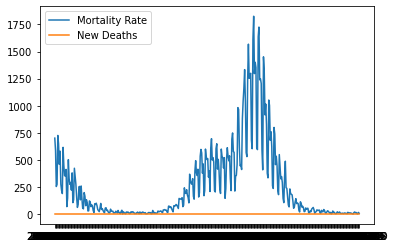

In [58]:
plt.plot(dataset_UK_models1["date"], dataset_UK_models1["new_deaths"])
plt.plot(dataset_UK_models1["date"], dataset_UK_models1["Mortality_Rate"])

plt.legend(["Mortality Rate", "New Deaths"], loc = "upper left")
plt.show()

In [59]:
dataset_UK_models1.drop(["new_deaths"], axis = 1, inplace = True)

In [60]:
dataset_UK_models1.head()

,date,reproduction_rate,icu_patients,Mortality_Rate
90078,2020-05-01,0.94,2178.0,0.000010
90079,2020-05-02,0.90,2068.0,0.000009
90080,2020-05-03,0.87,2009.0,0.000004
90081,2020-05-04,0.82,1936.0,0.000004
90082,2020-05-05,0.81,1874.0,0.000011


In [61]:
fig = px.line(dataset_UK_models1,  dataset_UK_models1["date"], dataset_UK_models1["reproduction_rate"], title = "Reproduction Rate", hover_data = ["Mortality_Rate"]) #hover_data = ["new_deaths", "population", "total_cases", "new_cases"])
fig.update_traces(mode = "markers + lines", hovertemplate = None)
fig.update_layout(hovermode = "x unified")
fig.show()

In [62]:
fig = px.line(dataset_UK_models1,  dataset_UK_models1["date"], dataset_UK_models1["icu_patients"], title = "ICU Patients", hover_data = ["Mortality_Rate"]) #hover_data = ["new_deaths", "population", "total_cases", "new_cases"])
fig.update_traces(mode = "markers + lines", hovertemplate = None)
fig.update_layout(hovermode = "x unified")
fig.show()